# Pointcloud-to-Graph Delaunay Lifting Tutorial

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    load_dataset_config,
    load_model_config,
    load_transform_config,
)
import matplotlib.pyplot as plt

## Loading the Dataset (ShapeNet)


In [2]:
dataset_name = "ShapeNet"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for ShapeNet:

{'data_domain': 'point_cloud',
 'data_type': 'ShapeNet',
 'data_name': 'ShapeNet',
 'data_dir': 'datasets/point_cloud/ShapeNet',
 'num_features': 3,
 'num_classes': 50,
 'category': 'plane',
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'graph'}


In [3]:
dataset = loader.load()
# describe_data(dataset)

In [4]:
dataset[0].pos.shape

torch.Size([2252, 3])

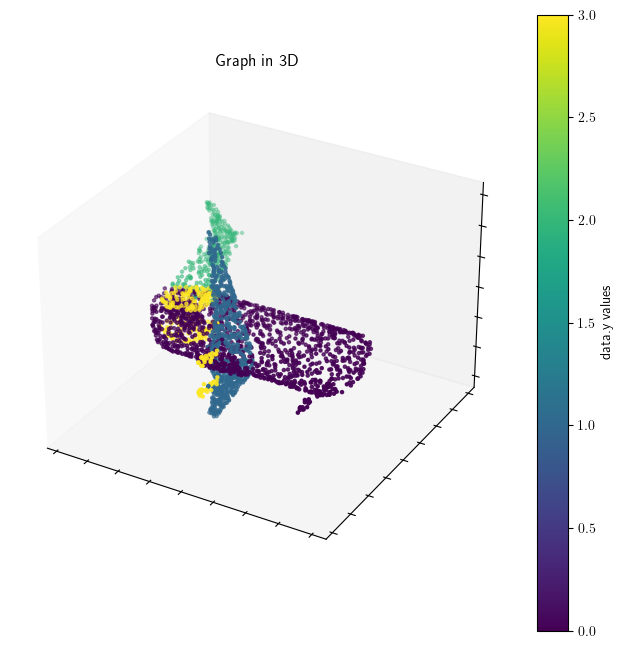

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np

# Assuming dataset[0].pos and dataset[0].y are defined
pos = dataset[1].pos
y = dataset[1].y

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Use a colormap to map the values in data.y to colors
# 'viridis' is a good default choice for a colormap, but you can choose another
scatter = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=y, cmap="viridis", s=5)

# Add a colorbar to the plot to show the mapping from data.y values to colors
plt.colorbar(scatter, ax=ax, label="data.y values")

# Set the title and remove grid, labels, and background
ax.set_title("Graph in 3D")
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])  # Also remove z labels
ax.set_facecolor("none")

# Rotate the axes with the mouse
# ax.view_init(elev=20, azim=30)

# Show the plot
plt.show()

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np
# import imageio

# # Assuming dataset[1].pos and dataset[1].y are defined
# pos = dataset[1].pos
# y = dataset[1].y

# # Function to create and return the 3D scatter plot as an image array


# def create_3d_scatter(elev=30, azim=30):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     scatter = ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=y, cmap='viridis', s=5)
#     ax.view_init(elev=elev, azim=azim)
#     ax.grid(False)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     ax.set_zticklabels([])
#     ax.set_facecolor('none')
#     # Convert the Matplotlib figure to an image array
#     fig.canvas.draw()  # Draw the figure
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     plt.close(fig)  # Close the figure to free memory
#     return image


# # Create a list to hold the image frames
# frames = []

# # Generate frames by rotating the azimuth angle
# for azim in range(0, 360, 10):  # Adjust the step and range as needed
#     frame = create_3d_scatter(elev=20, azim=azim)
#     frames.append(frame)

# # Save frames as a GIF
# imageio.mimsave('3d_scatter_rotation.gif', frames, fps=10)

In [7]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2graph/delaunay_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2graph/delaunay_lifting:

{'transform_type': 'lifting',
 'transform_name': 'GraphDelaunayLifting',
 'feature_lifting': 'ProjectionSum'}


In [8]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
# describe_data(lifted_dataset)

Transform parameters are the same, using existing data_dir: /home/jinh/icml24/challenge-icml-2024/datasets/point_cloud/ShapeNet/ShapeNet/lifting/1731765996


In [9]:
# from torch_geometric.utils import to_networkx
# import networkx as nx
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# data = lifted_dataset[1]
# G = to_networkx(data,to_undirected=True)
# for i, node in enumerate(G.nodes()):
#     G.nodes[node]['pos'] = data.pos[i].numpy()
# node_colors = data.y.numpy()
# pos = nx.get_node_attributes(G, 'pos')
# # node_xyz = np.array(pos[v] for v in sorted(G))
# node_xyz = np.array(list(pos.values()))
# edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# # Create the 3D figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")

# # Plot the nodes - alpha is scaled by "depth" automatically
# ax.scatter(*node_xyz.T, s=5, c=node_colors)

# for vizedge in edge_xyz:
#     ax.plot(*vizedge.T, color="tab:gray")

# ax.grid(False)
# # Suppress tick labels
# for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
#     dim.set_ticks([])
# # Set axes labels
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# fig.tight_layout()

## Create and Run a GraphSage Model

In [10]:
from modules.models.graph.graphsage import GraphSAGEModel

model_type = "graph"
model_id = "graphsage"
model_config = load_model_config(model_type, model_id)

model = GraphSAGEModel(model_config, dataset_config)


Model configuration for graph GRAPHSAGE:

{'in_channels': -1, 'hidden_channels': 32, 'out_channels': None, 'n_layers': 2}


In [11]:
y_hat = model(lifted_dataset.get(0))